# Bayesian Latent Model with Synthetic Data

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from data.synthetic import Generator
from utils import helper_functions as hf

## Metadata for the Model

In [3]:
n = 1000
d = [3, 4]
q = 2
min_len = 10
max_len = 15
max_time = 16

## Model

In [4]:
model = Generator(n, d, q, min_len, max_len, max_time)

## Meta Data

In [5]:
model_metadata = model.metadata
model_metadata

{'n': 1000, 'd': [3, 4], 'q': 2, 'min_len': 10, 'max_len': 15, 'max_time': 16}

## Attributes

In [6]:
model_attributes = model.attributes

## Parameters

In [7]:
model_params = model.params
model_params

{'mu': [array([-0.43579775,  0.47164039,  0.38581529]),
  array([-0.08148652, -0.85784612, -0.53742877, -0.28893987])],
 'omega': [array([-0.10104521, -0.93961443, -0.8753014 ]),
  array([-0.62687063, -0.15048581,  0.54465568, -0.33809745])],
 'w': [array([[ 0.28568527,  0.44334695],
         [ 0.81736797, -0.16088141],
         [ 0.19477364, -0.9057144 ]]),
  array([[-0.85366179,  0.05078137],
         [-0.60400981,  0.68078474],
         [-0.96194957, -0.56002611],
         [-0.68252221,  0.6026942 ]])],
 'v': [array([[ 0.85938621,  0.436375  ],
         [ 0.47190811,  0.2226434 ],
         [-0.13214207,  0.06672266]]),
  array([[ 0.23173337,  0.22327806],
         [ 0.65021952, -0.67692363],
         [-0.11070885, -0.46746666],
         [-0.82917086, -0.34162296]])],
 'sigma2': [1.004030686668338, 1.0266459750167276]}

## Time Sequence Plot

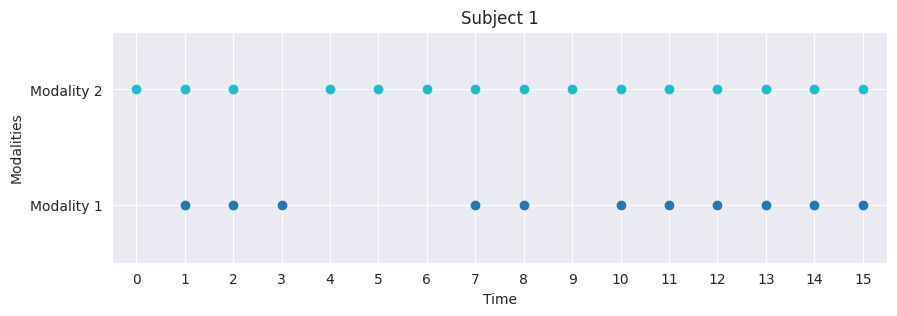

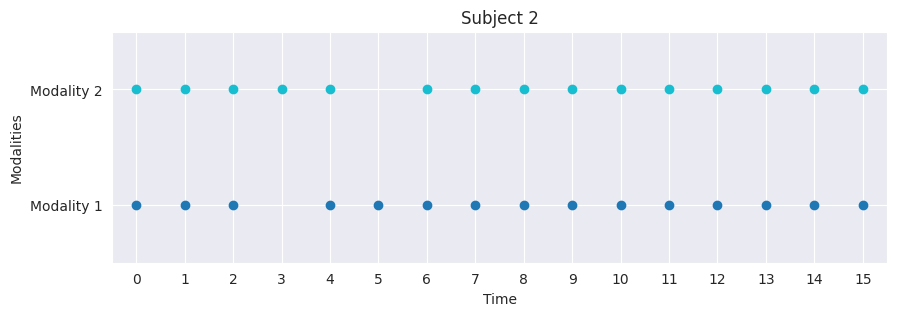

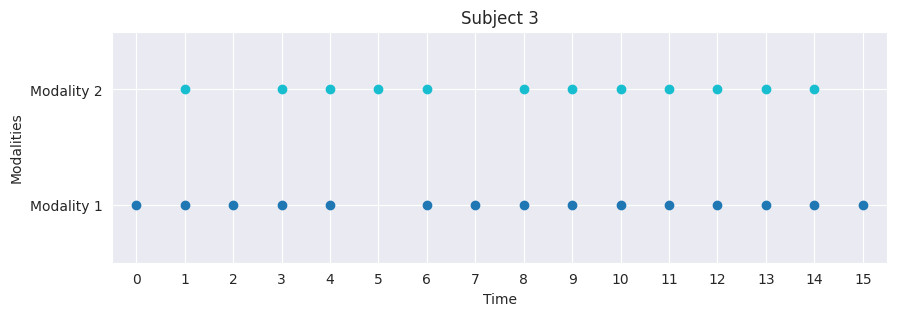

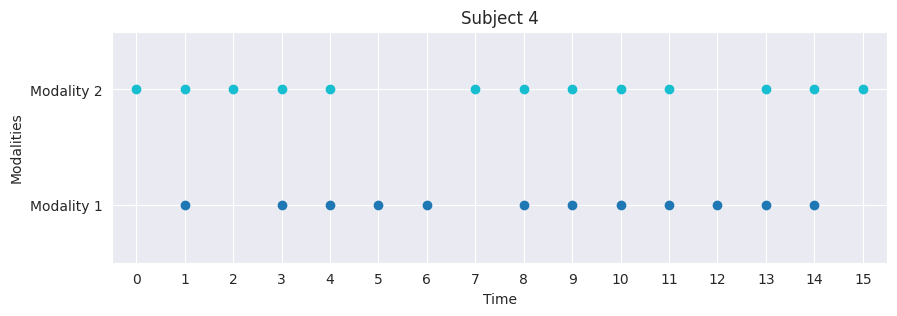

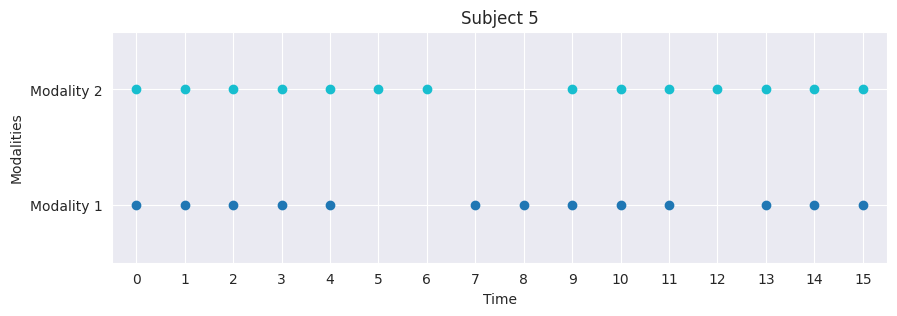

In [8]:
model.plot_t(subject_indices=[0, 1, 2, 3, 4])

## Data Generation

In [9]:
d = model.metadata['d']
n = model.metadata['n']
t = model.attributes['t']
w_actual = model.params['w']
v_actual = model.params['v']
omega_actual = model.params['omega']
mu_actual = model.params['mu']
sigma2_actual = model.params['sigma2']

In [10]:
def generate_concentric_rings(radius1=1, radius2=2, noise=0.1, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Randomly choose a circle (ring)
    chosen_radius = np.random.choice([radius1, radius2])

    # Generate a random angle between 0 and 2pi
    angle = np.random.uniform(0, 2 * np.pi)

    # Generate x and y coordinates for the point on the chosen circle
    x = chosen_radius * np.cos(angle)
    y = chosen_radius * np.sin(angle)

    # Add some Gaussian noise to x and y coordinates
    x += np.random.normal(scale=noise)
    y += np.random.normal(scale=noise)

    return np.array([[x, y]])

In [11]:
def generate_distributions(n, noise=None, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Container for all the data points
    data_points = []

    # Containers for each distribution's indices
    d1_indices, d2_indices, d3_indices = [], [], []

    for i in range(n):
        # Randomly choose a distribution
        dist_choice = np.random.choice(3)

        # 1. Normal distribution (placed at the center)
        if dist_choice == 0:
            mean = [0, 0]
            cov = [[1, 0], [0, 1]]  # unit variance
            point = np.random.multivariate_normal(mean, cov, 1)
            d1_indices.append(i)

        # 2. Ring distribution (placed in top-right quadrant)
        elif dist_choice == 1:
            point = generate_concentric_rings(radius1=1, radius2=2, noise=.05)
            point += [3.5, 3.5]  # Shift mean
            d2_indices.append(i)

        # 3. Line segment (y=x) (placed in top-left quadrant)
        elif dist_choice == 2:
            x = np.random.uniform(-1, 1) + np.random.normal(0, 0.1, 1) # add noise
            point = np.column_stack((x, x+4)) # shift mean
            d3_indices.append(i)

        data_points.append(point)

    # Combine all distributions and convert to numpy array
    data_points = np.concatenate(data_points)

    # Add noise
    data_points += np.random.normal(scale=noise, size=data_points.shape)

    return data_points, d1_indices, d2_indices, d3_indices


In [12]:
# Test
x_actual, d1_indices, d2_indices, d3_indices = generate_distributions(n, noise=0.1)

In [13]:
index_color_tuples = [
    (d1_indices, 'b'),
    (d2_indices, 'g'),
    (d3_indices, 'r')
]

In [14]:
import seaborn as sns
import  itertools

def plot_scatter_pairs_latent(data, index_color_tuples=None, point_size=15):

    num_points, num_dimensions = data.shape
    dimension_pairs = list(itertools.combinations(range(num_dimensions), 2))

    num_plots = len(dimension_pairs)
    plt.figure(figsize=(num_plots*5, 5))

    for idx, (dim1, dim2) in enumerate(dimension_pairs):
        plt.subplot(1, num_plots, idx + 1)

        if index_color_tuples is None:
            sns.scatterplot(x=data[:, dim1], y=data[:, dim2], s=point_size)
        else:
            for indices, color in index_color_tuples:
                sns.scatterplot(x=data[indices, dim1], y=data[indices, dim2], s=point_size, color=color)

        plt.xlabel(f'Dimension {dim1 + 1}')
        plt.ylabel(f'Dimension {dim2 + 1}')
        plt.title(f'Scatter plot of dimensions {dim1 + 1} and {dim2 + 1}')

    plt.tight_layout()
    plt.show()


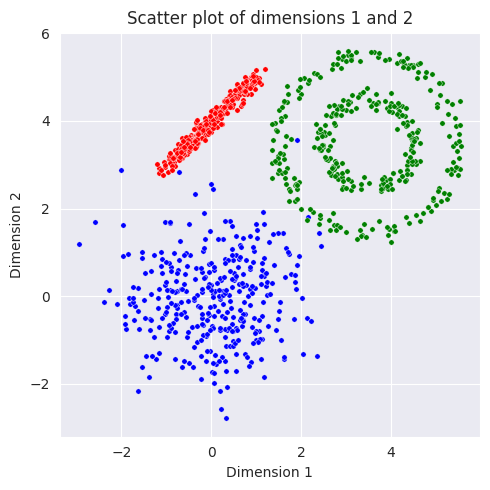

In [15]:
plot_scatter_pairs_latent(x_actual, index_color_tuples)

In [16]:
x = x_actual
w = w_actual
v = v_actual
omega = omega_actual
mu = mu_actual
sigma2 = sigma2_actual
y = []
noise = True
for i in range(n):
    y_n = []
    for k in range(len(d)):
        y_nk = ((t[i][k].reshape(-1, 1, 1) * w[k] + v[k]) * x[i]).sum(2) + t[i][k].reshape(-1, 1) * omega[k] + mu[k]
        if noise:
            epsilon = np.array([])
            for j in range(len(t[i][k])):
                rnd = np.random.RandomState(23 + i + k + j)
                eps = rnd.multivariate_normal(np.zeros(d[k]),
                                                    np.eye(d[k]) * sigma2[k])
                epsilon = np.append(epsilon, eps)
            epsilon = epsilon.reshape(len(t[i][k]), d[k])
            y_nk += epsilon
        y_n.append(y_nk)
    y.append(y_n)

y_actual = y

## Input Observed Data

import seaborn as sns

def plot_scatter_pairs_observed(data, subject_color_tuples=None, point_size=30):
    data = np.array(data, dtype="object")
    _, modality_index = data.shape

    for modality_index in range(modality_index):
        subjects_data = np.concatenate([subject[modality_index] for subject in data])
        subject_info = 'all subjects'

        num_points, num_dimensions = subjects_data.shape
        dimension_pairs = list(itertools.combinations(range(num_dimensions), 2))

        num_plots = len(dimension_pairs)
        num_rows = int(np.ceil(num_plots / 2))  # Arrange plots in a 2-column grid
        fig, axs = plt.subplots(num_rows, 2, figsize=(15, 10*num_rows), dpi=100)

        for idx, (dim1, dim2) in enumerate(dimension_pairs):
            ax = axs.flatten()[idx]

            if subject_color_tuples is None:
                sns.scatterplot(x=subjects_data[:, dim1], y=subjects_data[:, dim2], s=point_size, ax=ax)
            else:
                sns.scatterplot(x=subjects_data[:, dim1], y=subjects_data[:, dim2], s=point_size, label='Others', ax=ax)
                for subject_indices, color in subject_color_tuples:
                    subjects_data_color = np.concatenate([data[i][modality_index] for i in subject_indices])
                    sns.scatterplot(x=subjects_data_color[:, dim1], y=subjects_data_color[:, dim2], s=point_size, color=color, ax=ax)

            ax.set_xlabel(f'Dimension {dim1 + 1}', fontsize=14)
            ax.set_ylabel(f'Dimension {dim2 + 1}', fontsize=14)
            ax.set_title(f'Plot of dimensions {dim1 + 1} and {dim2 + 1} for modality {modality_index + 1}, {subject_info}', fontsize=18)
            ax.legend()

        # If num_plots is odd, remove the last (empty) subplot
        if num_plots % 2 != 0:
            fig.delaxes(axs.flatten()[-1])

        # Adjust the spacing
        fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

        plt.show()


In [17]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

def plot_scatter_pairs_observed(data, subject_color_tuples=None, point_size=30):
    data = np.array(data, dtype="object")
    _, modality_index = data.shape

    for modality_index in range(modality_index):
        subjects_data = np.concatenate([subject[modality_index] for subject in data])
        subject_info = 'all subjects'

        num_points, num_dimensions = subjects_data.shape
        dimension_pairs = list(itertools.combinations(range(num_dimensions), 2))

        for idx, (dim1, dim2) in enumerate(dimension_pairs):
            # Create a new figure for each scatter plot
            plt.figure(figsize=(15, 10), dpi=100)
            if subject_color_tuples is None:
                sns.scatterplot(x=subjects_data[:, dim1], y=subjects_data[:, dim2], s=point_size)
            else:
                sns.scatterplot(x=subjects_data[:, dim1], y=subjects_data[:, dim2], s=point_size, label='Others')
                for subject_indices, color in subject_color_tuples:
                    subjects_data_color = np.concatenate([data[i][modality_index] for i in subject_indices])
                    sns.scatterplot(x=subjects_data_color[:, dim1], y=subjects_data_color[:, dim2], s=point_size, color=color)

            plt.xlabel(f'Dimension {dim1 + 1}', fontsize=14)
            plt.ylabel(f'Dimension {dim2 + 1}', fontsize=14)
            plt.title(f'Plot of dimensions {dim1 + 1} and {dim2 + 1} for modality {modality_index + 1}, {subject_info}', fontsize=18)
            plt.legend()

            # Display each scatter plot separately and wait for the user to close the window
            plt.show()

# Sample call for testing purposes
# You can generate some mock data and call the function to test it.


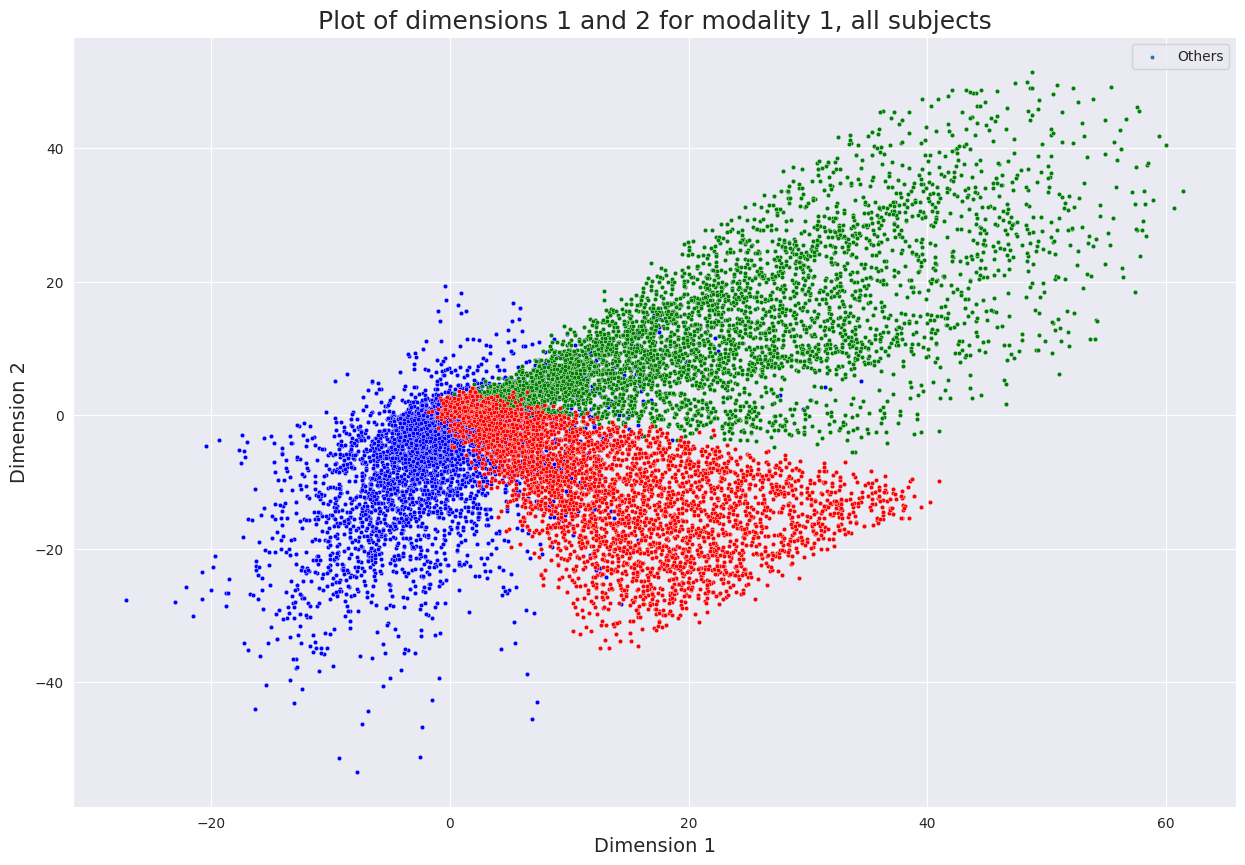

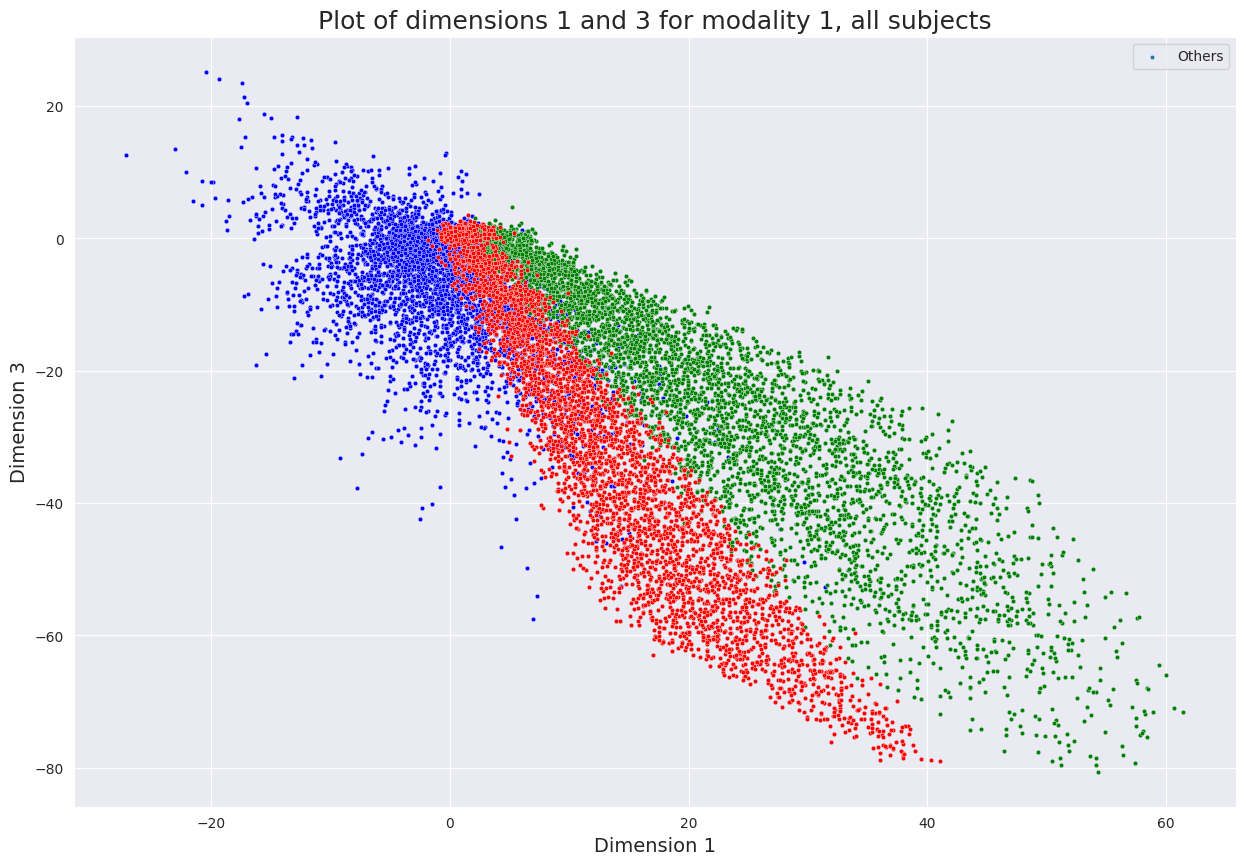

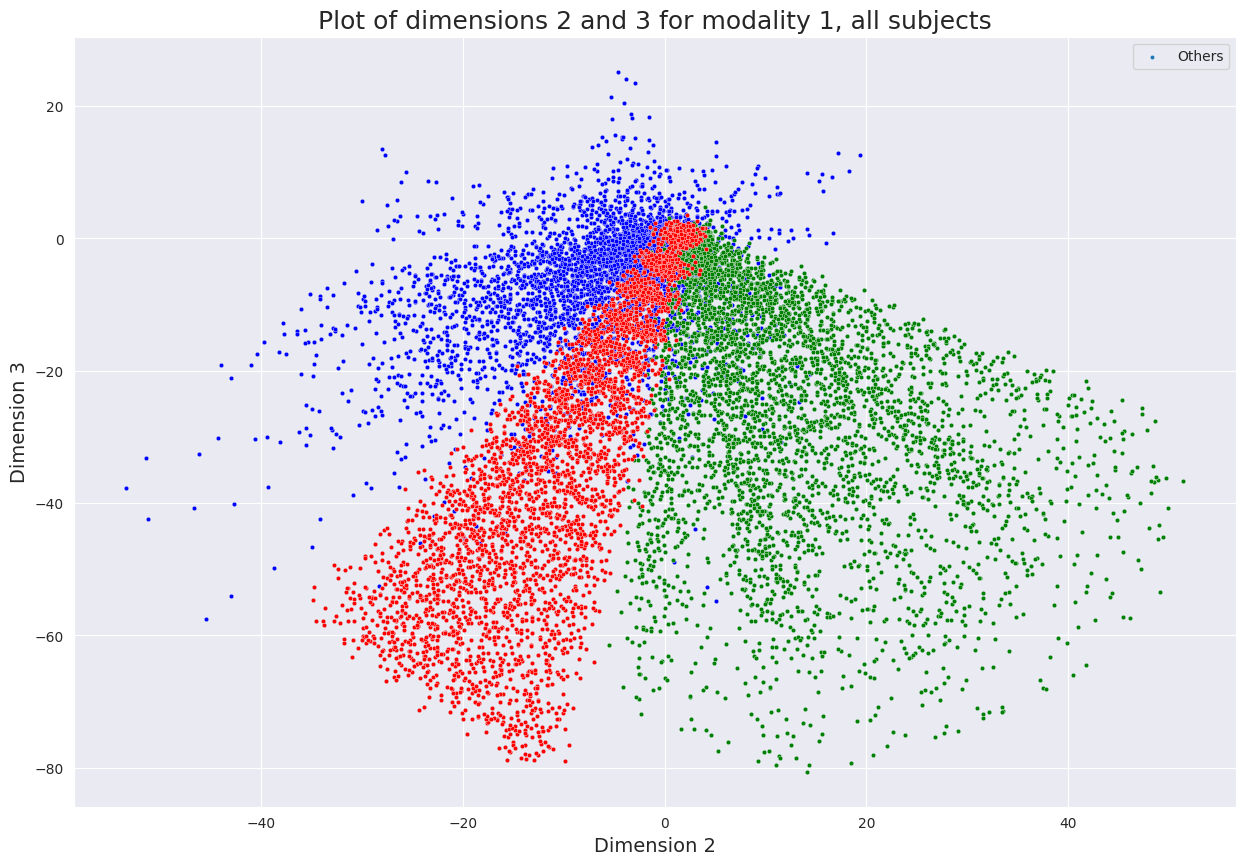

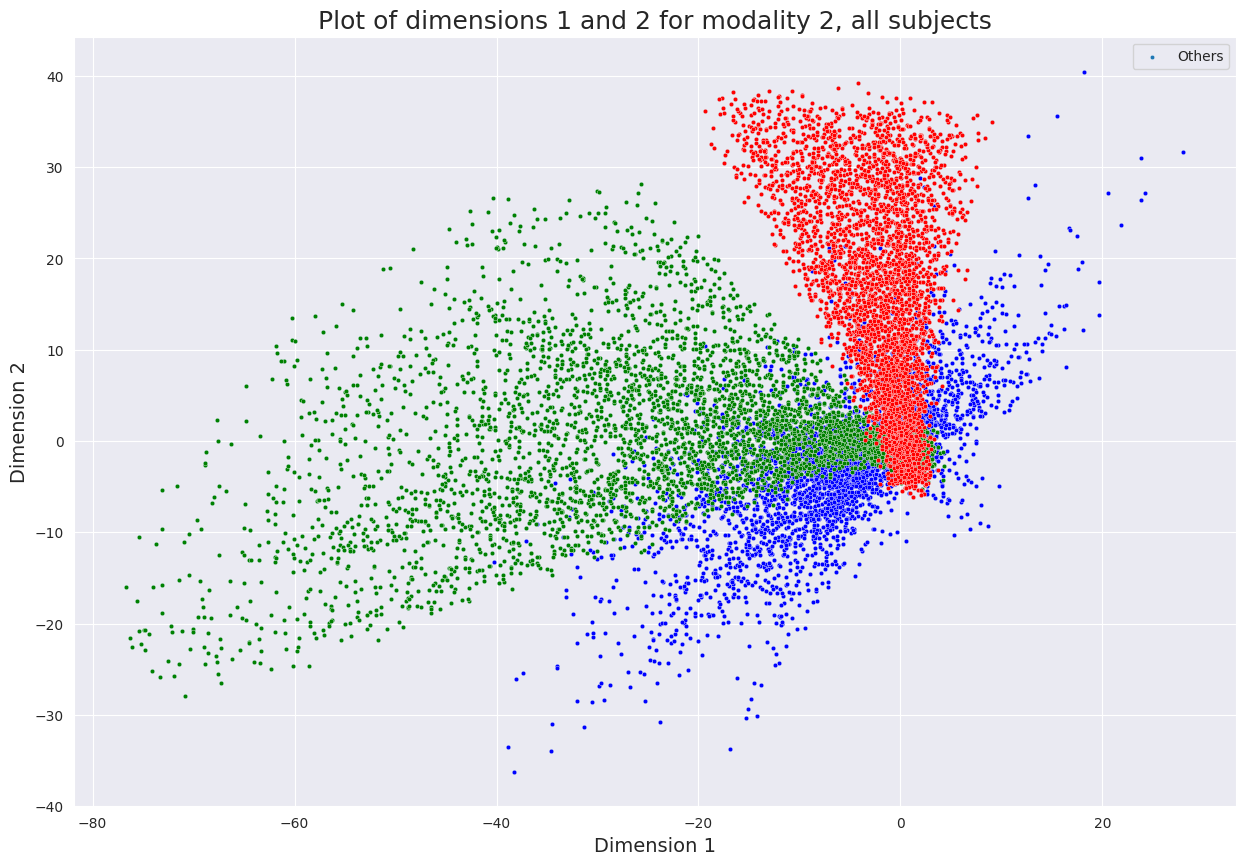

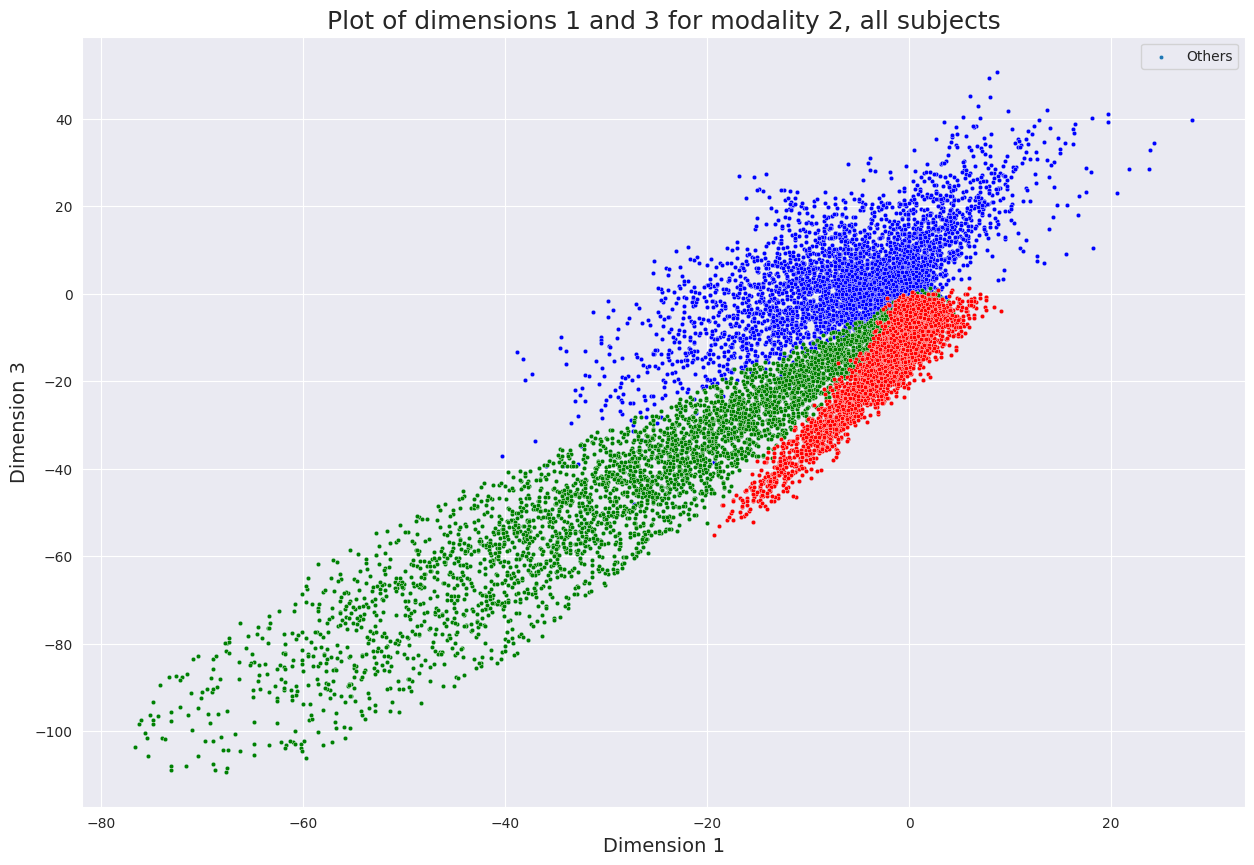

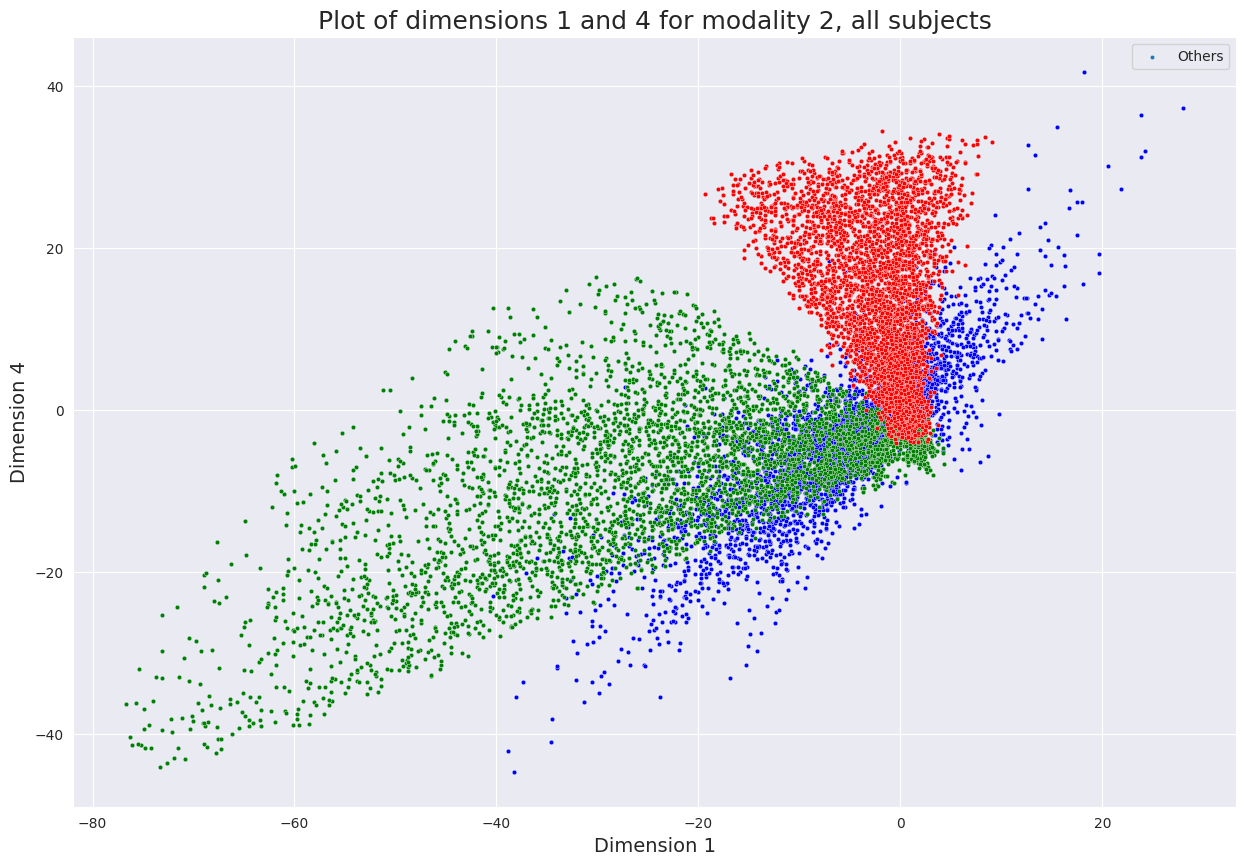

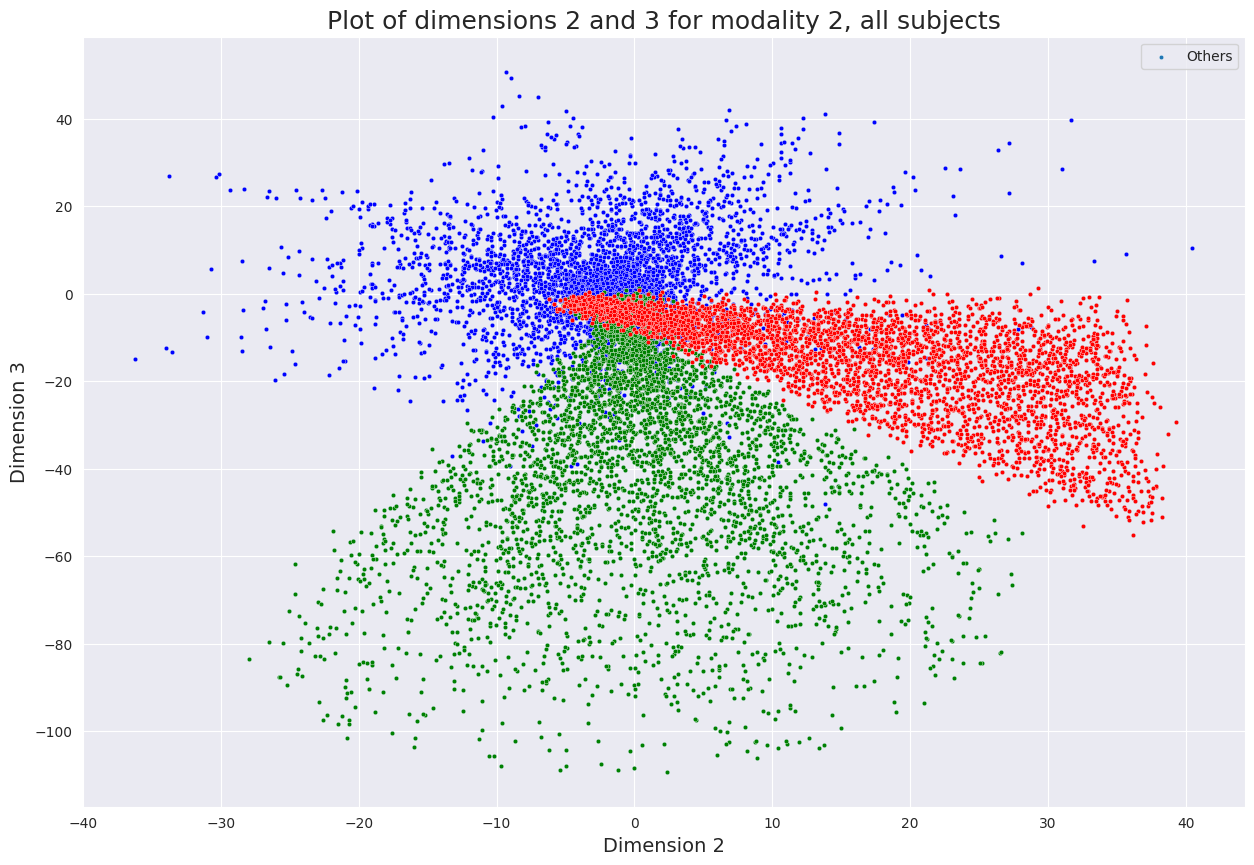

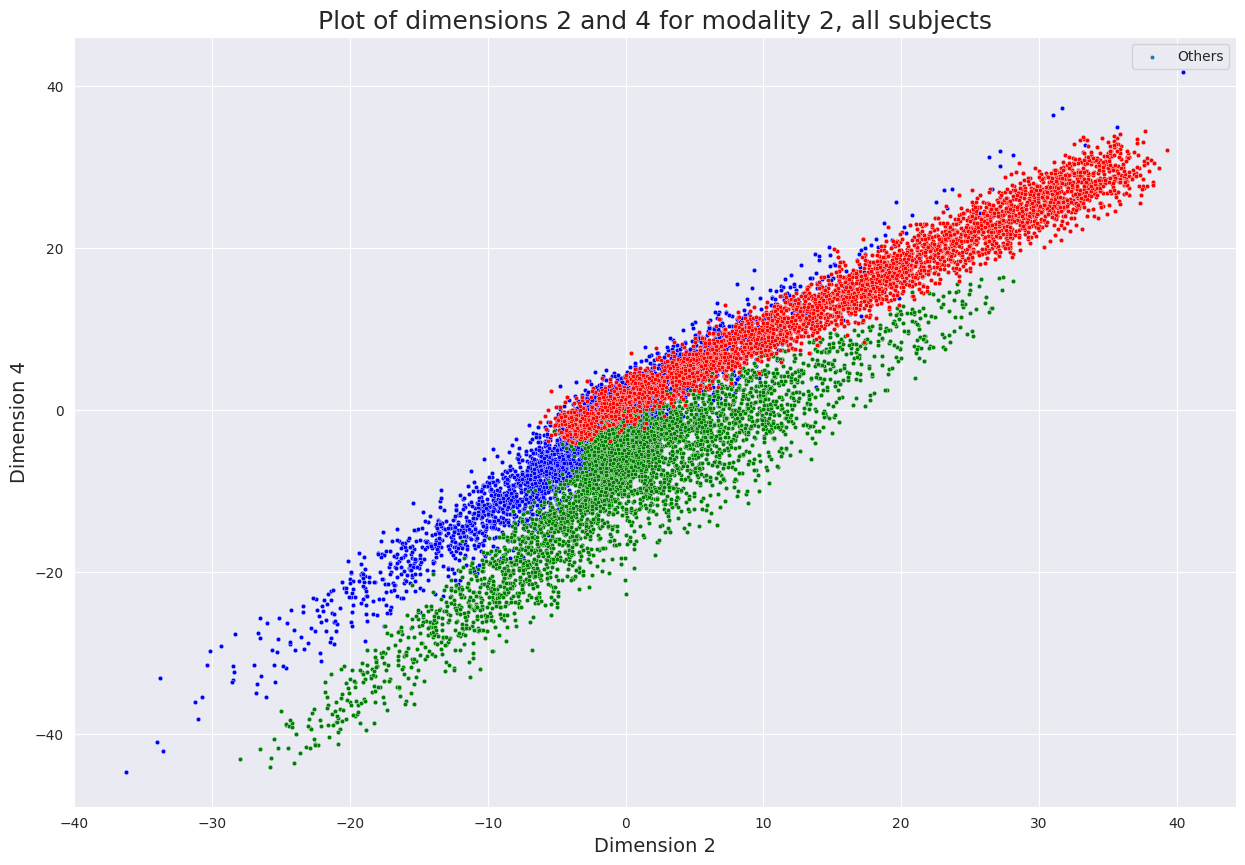

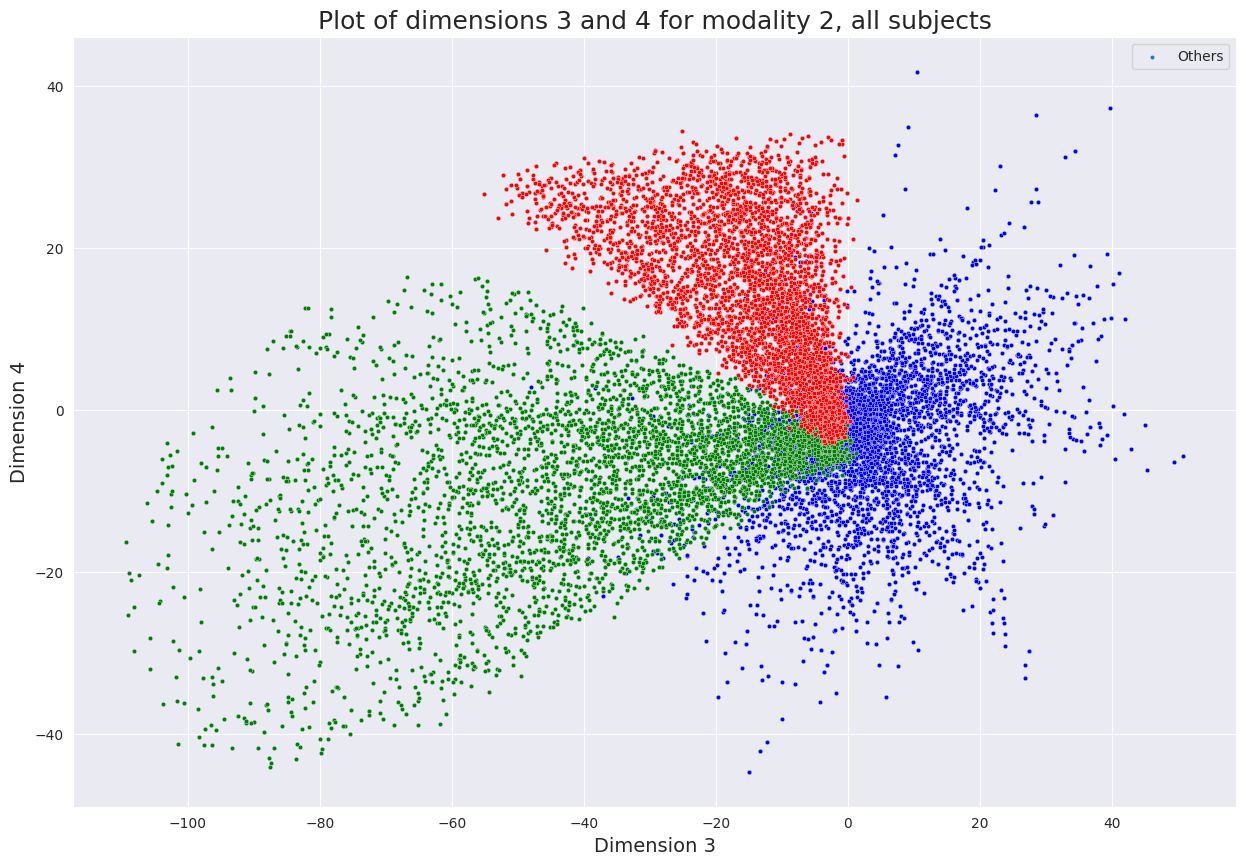

In [18]:
plot_scatter_pairs_observed(y_actual, subject_color_tuples=index_color_tuples, point_size=10)

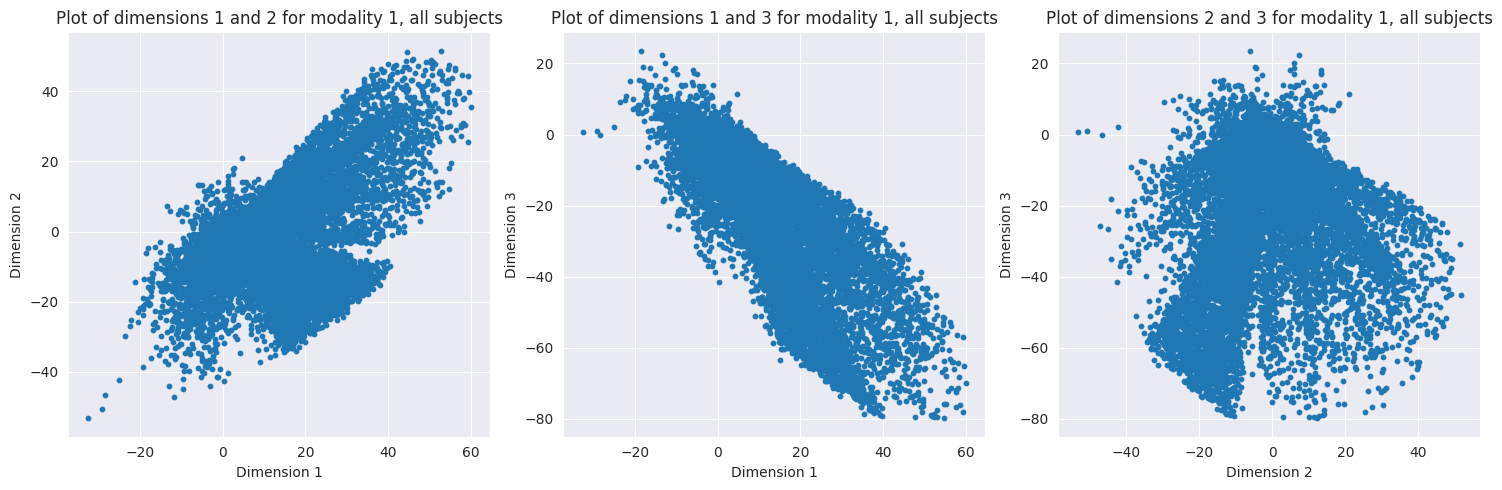

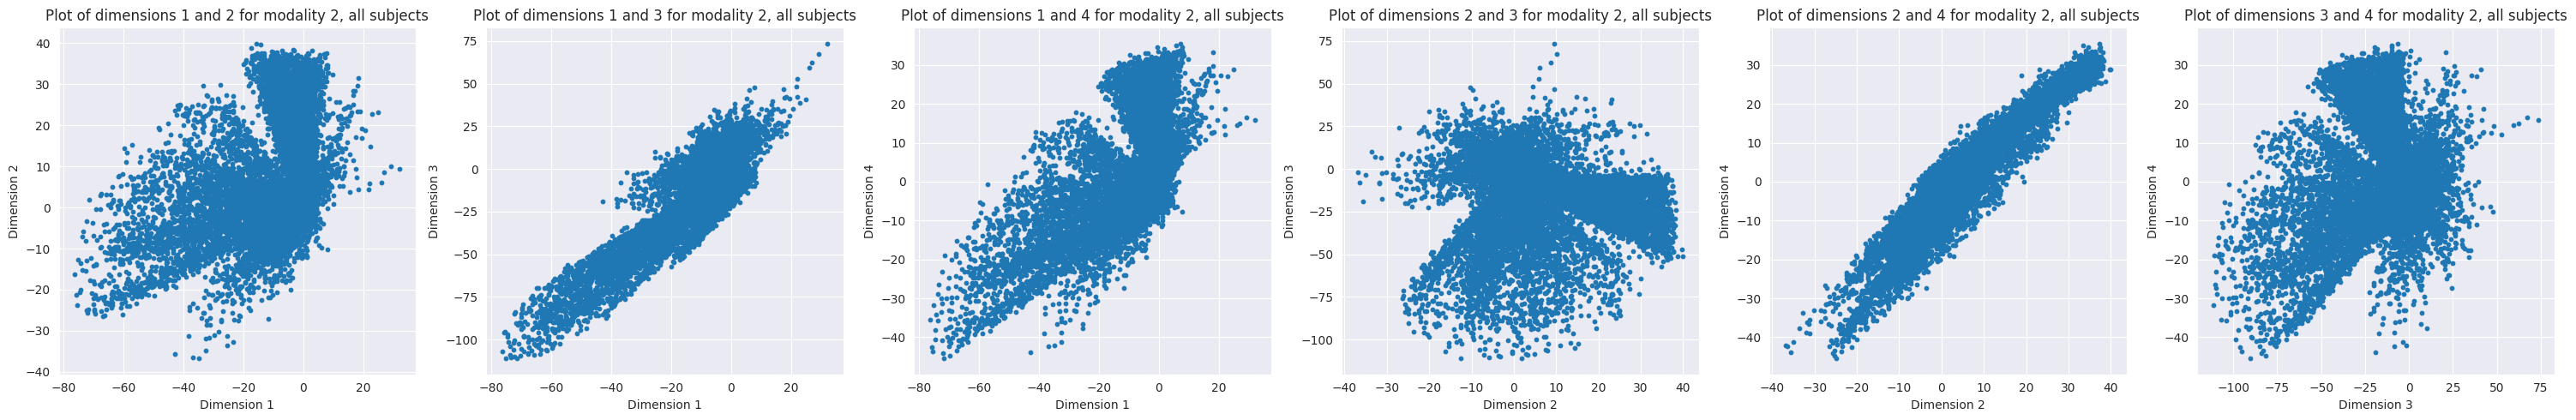

In [18]:
hf.plot_scatter_pairs_observed(y_actual)

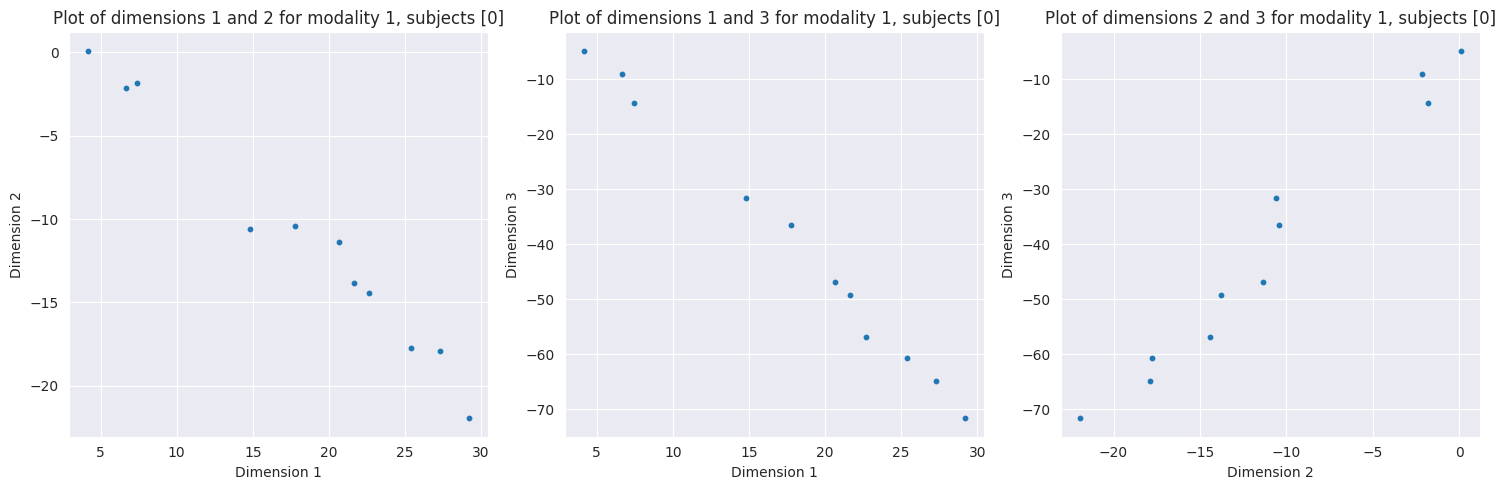

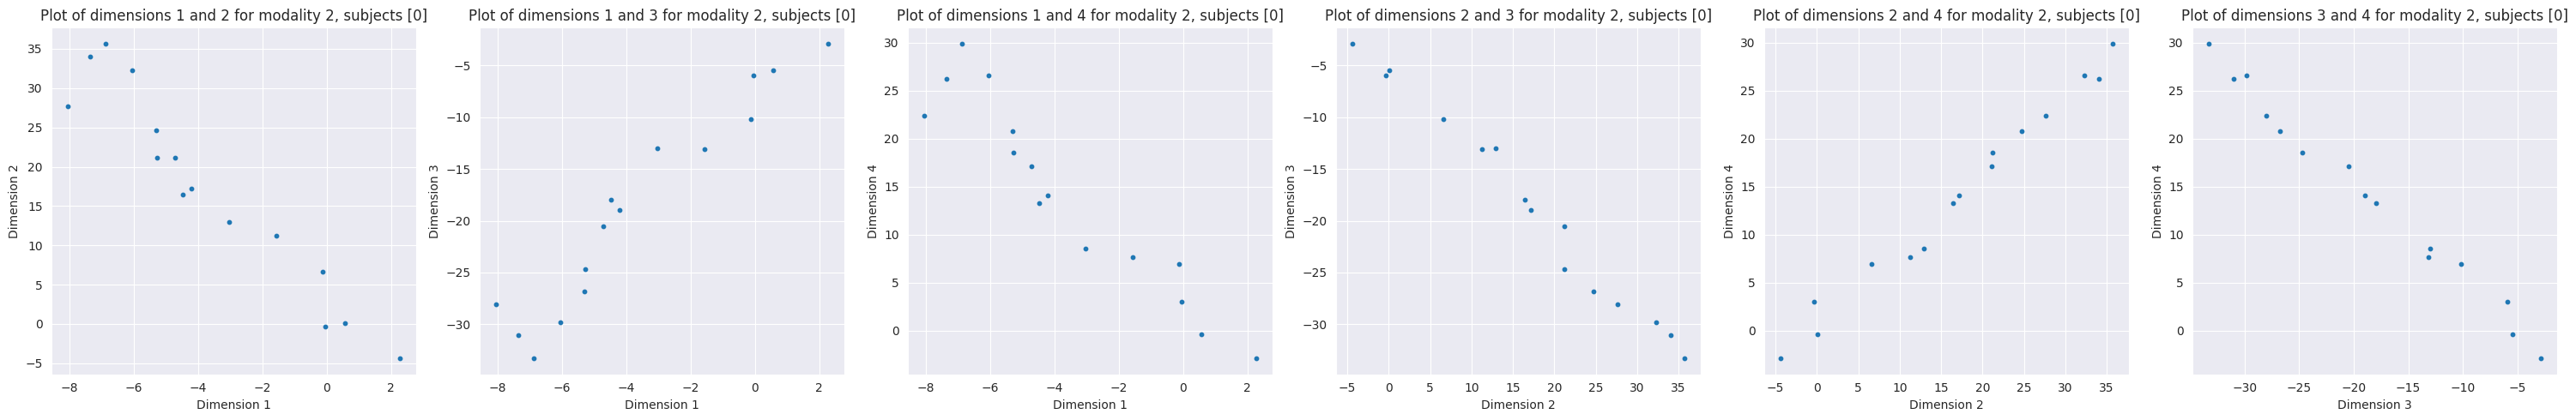

In [19]:
hf.plot_scatter_pairs_observed(y_actual, subject_indices=[0])

In [20]:
mae_results = []
marginal_likelihood_results = []
mae_std_results = []
marginal_likelihood_std_results = []
q_values = range(1, 10)
n_folds = 5
y_actual_np = np.array(y_actual, dtype=object)

for q in q_values:
    print('q=', q)
    mae_q = []
    marginal_likelihood_q = []

    for cv in range(n_folds):
        print('q=', q, '& cv fold is', cv)
        # Initialize the parameters
        mu_init, omega_init, w_init, v_init, sigma2_init = hf.random_params(d, q, seed=None)

        # Fit the model and get the optimized parameters
        w_opt, v_opt, mu_opt, omega_opt, sigma2_opt, training_history = hf.fit(
            y_actual, w_init, v_init, mu_init, omega_init, sigma2_init, t, n_epochs=50, history=True)

        # Compute the posterior moments
        posterior_mean, _, posterior_variance = hf.posterior_moments(
            y_actual, w_opt, v_opt, mu_opt, omega_opt, sigma2_opt, t)

        # Reconstruct "x"
        x_recon = np.zeros((n, q))
        for i in range(n):
            rnd = np.random.default_rng()
            x_recon[i] = rnd.multivariate_normal(mean=posterior_mean[i], cov=posterior_variance[i])

        # Reconstruct "y"
        y_recon = hf.decode(x_recon, w_opt, v_opt, mu_opt, omega_opt, sigma2_opt, t, seed=None, noise=True)
        y_recon_np = np.array(y_recon, dtype=object)

        # Compute the MAE
        mae_total, _ = hf.mae(y_actual_np, y_recon_np)

        # Append the results
        mae_q.append(mae_total)
        marginal_likelihood_q.append(training_history[-1])

    # Compute the average MAE and marginal likelihood for "q" and append to the results
    mae_results.append(np.mean(mae_q))
    marginal_likelihood_results.append(np.mean(marginal_likelihood_q))
    mae_std_results.append(np.std(mae_q))
    marginal_likelihood_std_results.append(np.std(marginal_likelihood_q))


q= 1
q= 1 & cv fold is 0
q= 1 & cv fold is 1
q= 1 & cv fold is 2
q= 1 & cv fold is 3
q= 1 & cv fold is 4
q= 2
q= 2 & cv fold is 0
q= 2 & cv fold is 1
q= 2 & cv fold is 2
q= 2 & cv fold is 3
q= 2 & cv fold is 4
q= 3
q= 3 & cv fold is 0
q= 3 & cv fold is 1
q= 3 & cv fold is 2
q= 3 & cv fold is 3
q= 3 & cv fold is 4
q= 4
q= 4 & cv fold is 0
q= 4 & cv fold is 1
q= 4 & cv fold is 2
q= 4 & cv fold is 3
q= 4 & cv fold is 4
q= 5
q= 5 & cv fold is 0
q= 5 & cv fold is 1
q= 5 & cv fold is 2
q= 5 & cv fold is 3
q= 5 & cv fold is 4
q= 6
q= 6 & cv fold is 0
q= 6 & cv fold is 1
q= 6 & cv fold is 2
q= 6 & cv fold is 3
q= 6 & cv fold is 4
q= 7
q= 7 & cv fold is 0
q= 7 & cv fold is 1
q= 7 & cv fold is 2
q= 7 & cv fold is 3
q= 7 & cv fold is 4
q= 8
q= 8 & cv fold is 0
q= 8 & cv fold is 1
q= 8 & cv fold is 2
q= 8 & cv fold is 3
q= 8 & cv fold is 4
q= 9
q= 9 & cv fold is 0
q= 9 & cv fold is 1
q= 9 & cv fold is 2
q= 9 & cv fold is 3
q= 9 & cv fold is 4


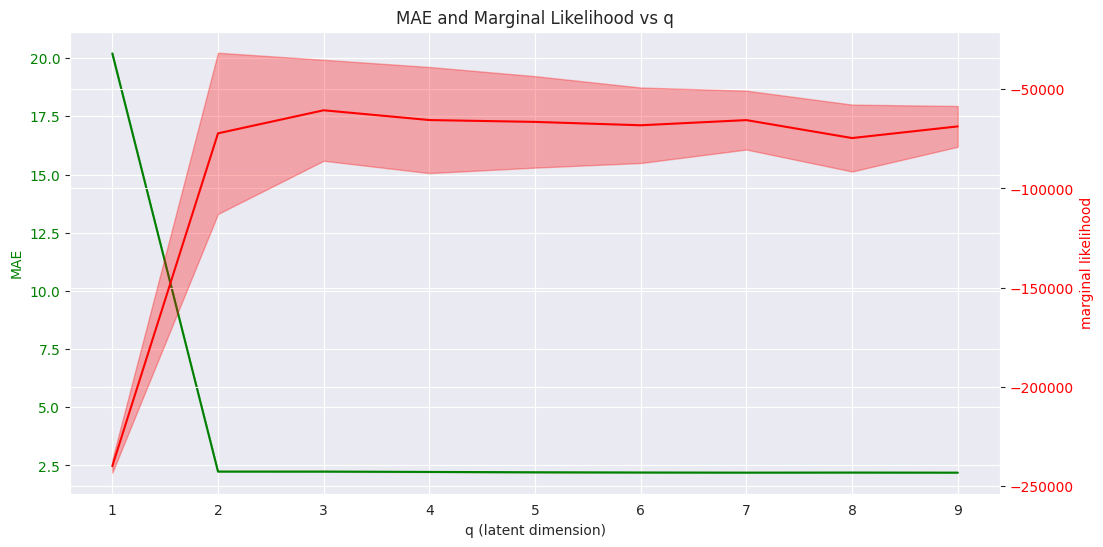

In [21]:
# Set the figure size
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the MAE results on the first y-axis
ax1.plot(q_values, mae_results, linestyle='solid', color='green', label='MAE')
ax1.fill_between(q_values, np.array(mae_results) - np.array(mae_std_results), np.array(mae_results) + np.array(mae_std_results), color='green', alpha=0.3)
ax1.set_xlabel('q (latent dimension)')
ax1.set_ylabel('MAE', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.grid(True)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the marginal likelihood results on the second y-axis
ax2.plot(q_values, marginal_likelihood_results, linestyle='solid', color='red', label='marginal likelihood')
ax2.fill_between(q_values, np.array(marginal_likelihood_results) - np.array(marginal_likelihood_std_results), np.array(marginal_likelihood_results) + np.array(marginal_likelihood_std_results), color='red', alpha=0.3)
ax2.set_ylabel('marginal likelihood', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a title
plt.title('MAE and Marginal Likelihood vs q')

# Show the plot
plt.show()

## Fitting data to the model

In [19]:
q = 2

In [20]:
# Parameter Initialization
mu_init, omega_init, w_init, v_init, sigma2_init = hf.random_params(d, q, seed=None)
mu_init, omega_init, w_init, v_init, sigma2_init

([array([-0.49486365,  0.81570533,  0.33253915]),
  array([-0.23748425, -0.83098515,  0.50816813,  0.90710974])],
 [array([-0.8532138 ,  0.61147151, -0.45979524]),
  array([-0.72110902,  0.05045781, -0.60617912,  0.46223433])],
 [array([[-0.14071387, -0.32925273],
         [-0.05869363, -0.63827535],
         [ 0.36186273,  0.62166764]]),
  array([[ 0.49591172,  0.49995667],
         [ 0.73293222,  0.63743877],
         [ 0.85788745,  0.85615682],
         [-0.9294644 ,  0.75132682]])],
 [array([[ 0.41727248,  0.59946405],
         [-0.35643771,  0.49609922],
         [ 0.90148486,  0.3146761 ]]),
  array([[-0.56613242,  0.55896434],
         [ 0.27628981, -0.1820501 ],
         [-0.11717756, -0.10165239],
         [-0.59358681, -0.8166833 ]])],
 [1.0212868622588551, 1.1605780731669815])

In [21]:
mu_actual, omega_actual, w_actual, v_actual, sigma2_actual

([array([-0.43579775,  0.47164039,  0.38581529]),
  array([-0.08148652, -0.85784612, -0.53742877, -0.28893987])],
 [array([-0.10104521, -0.93961443, -0.8753014 ]),
  array([-0.62687063, -0.15048581,  0.54465568, -0.33809745])],
 [array([[ 0.28568527,  0.44334695],
         [ 0.81736797, -0.16088141],
         [ 0.19477364, -0.9057144 ]]),
  array([[-0.85366179,  0.05078137],
         [-0.60400981,  0.68078474],
         [-0.96194957, -0.56002611],
         [-0.68252221,  0.6026942 ]])],
 [array([[ 0.85938621,  0.436375  ],
         [ 0.47190811,  0.2226434 ],
         [-0.13214207,  0.06672266]]),
  array([[ 0.23173337,  0.22327806],
         [ 0.65021952, -0.67692363],
         [-0.11070885, -0.46746666],
         [-0.82917086, -0.34162296]])],
 [1.004030686668338, 1.0266459750167276])

In [22]:
w_opt, v_opt, mu_opt, omega_opt, sigma2_opt, training_history = hf.fit(y_actual, w_init, v_init, mu_init, omega_init, sigma2_init, t, n_epochs=150, history=True)

## Likelihood Convergence

In [23]:
training_history

array([[-198981.67589152, -148455.98918552, -122980.43484146,
        -106644.32274953,  -94311.69681213,  -84813.18302657,
         -77387.70689474,  -71440.83593004,  -66593.21058496,
         -62621.25746373,  -59383.15679676,  -56772.36035954,
         -54696.04561833,  -53068.03450202,  -51808.37940594,
         -50845.06829643,  -50115.59511565,  -49567.58894788,
         -49158.48447993,  -48854.53398762,  -48629.50128875,
         -48463.29866076,  -48340.72483152,  -48250.37821881,
         -48183.76455085,  -48134.58761723,  -48098.19836328,
         -48071.1739484 ,  -48050.99990817,  -48035.8322369 ,
         -48024.32042327,  -48015.47643905,  -48008.57808463,
         -48003.09786629,  -47998.65076252,  -47994.95591956,
         -47991.80859341,  -47989.05961589,  -47986.60037773,
         -47984.35185318,  -47982.25658255,  -47980.27281853,
         -47978.3702541 ,  -47976.5269065 ,  -47974.72684527,
         -47972.95853684,  -47971.21363901,  -47969.48612357,
        

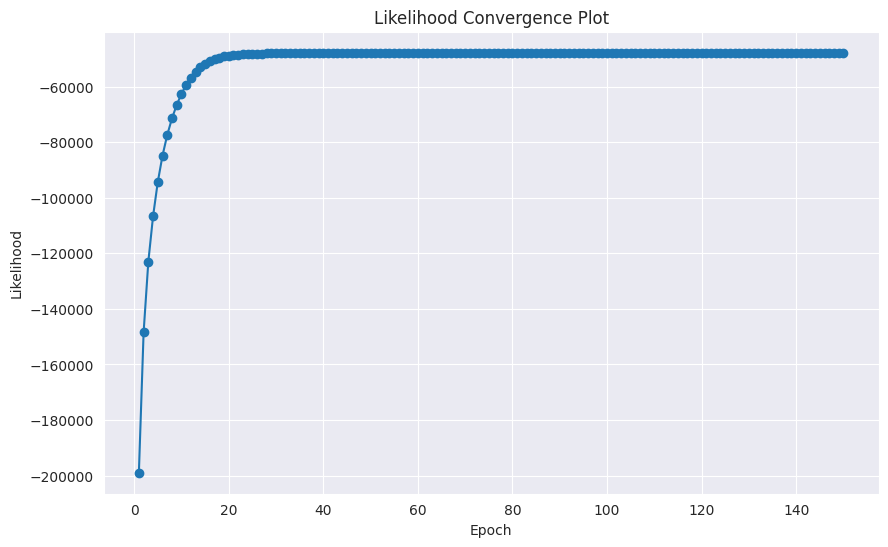

In [24]:
hf.plot_likelihood(training_history)

## Reconstruction

In [25]:
posterior_mean, _, posterior_variance = hf.posterior_moments(y_actual, w_opt, v_opt, mu_opt, omega_opt, sigma2_opt, t)

In [26]:
x_recon = np.zeros((n, q))
for i in range(n):
    rnd = np.random.default_rng()
    x_recon[i] = rnd.multivariate_normal(mean=posterior_mean[i], cov=posterior_variance[i])
x_recon

array([[ 1.0323496 , -0.84526976],
       [-1.21711593, -0.4181507 ],
       [-0.08957008, -3.6646842 ],
       ...,
       [-1.15980572, -4.05579516],
       [-0.63176934,  0.89717425],
       [-0.82558874, -2.47709734]])

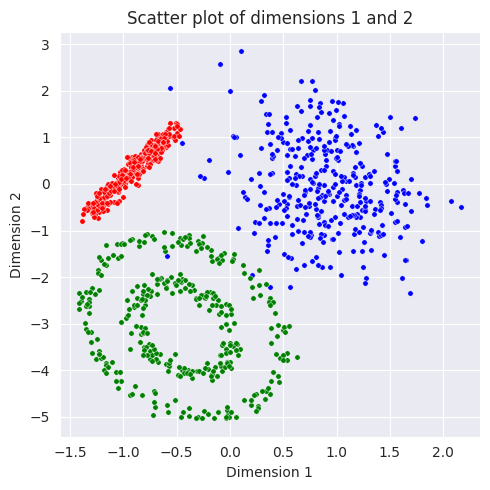

In [28]:
plot_scatter_pairs_latent(x_recon, index_color_tuples)

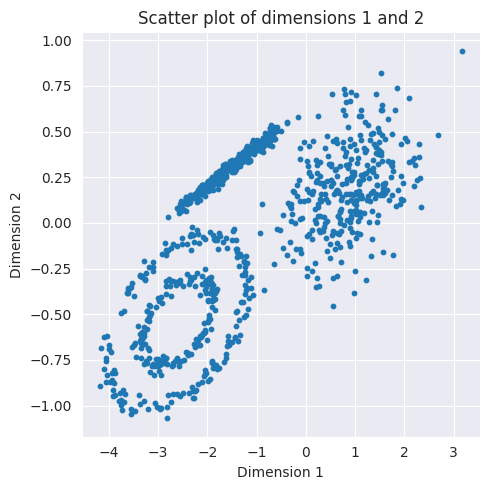

In [45]:
hf.plot_scatter_pairs_latent(x_recon)

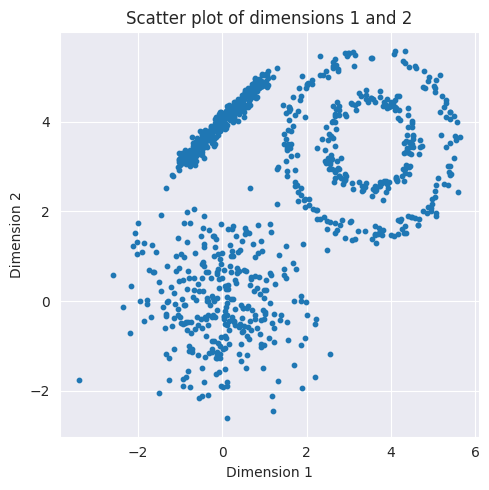

In [46]:
hf.plot_scatter_pairs_latent(x_actual)

In [47]:
y_recon = hf.decode(x_recon, w_opt, v_opt, mu_opt, omega_opt, sigma2_opt, t, seed=None, noise=True)

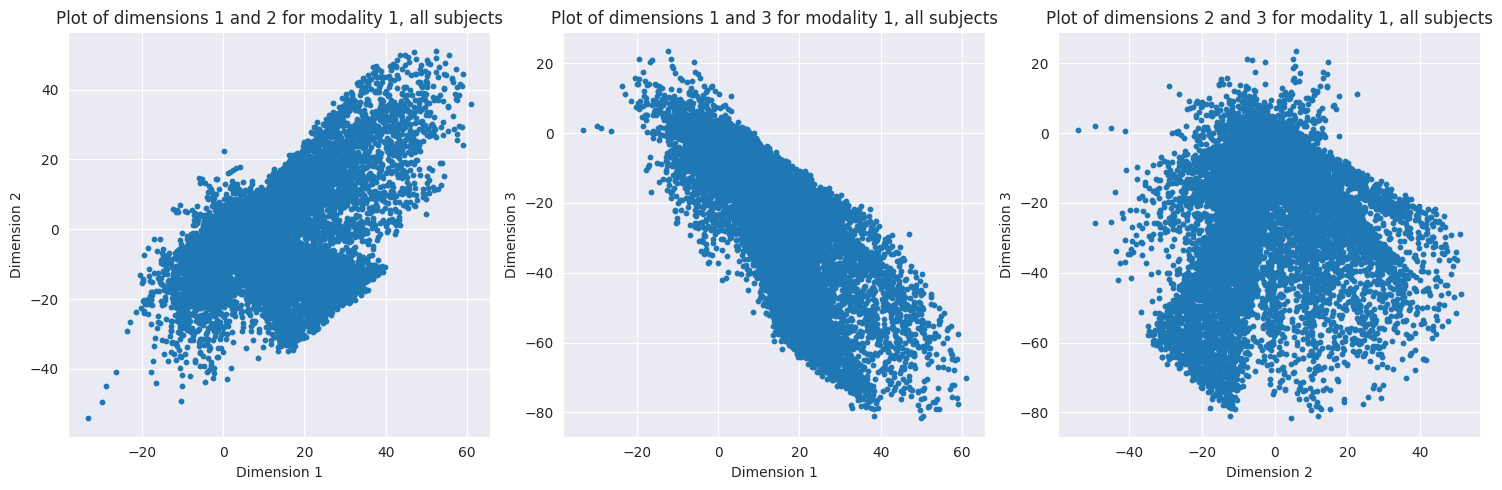

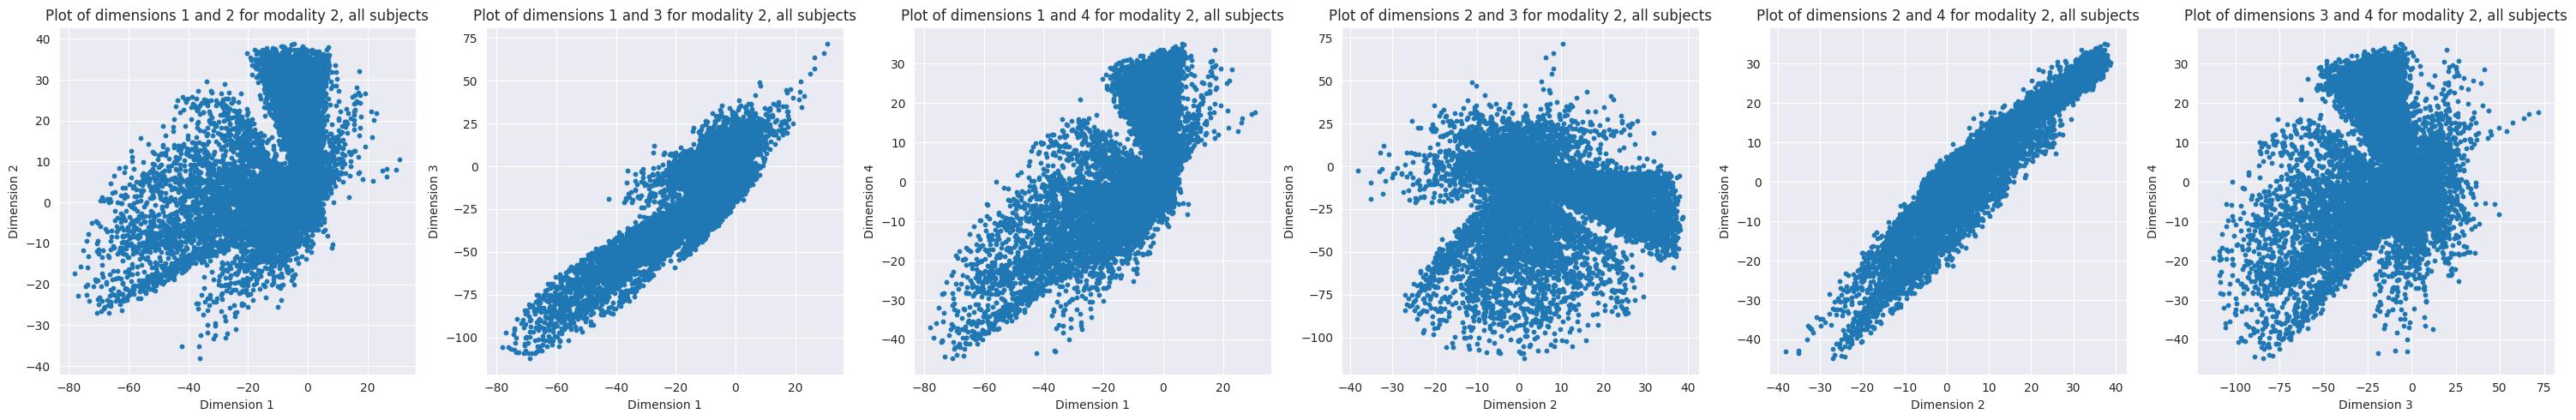

In [48]:
hf.plot_scatter_pairs_observed(y_recon)

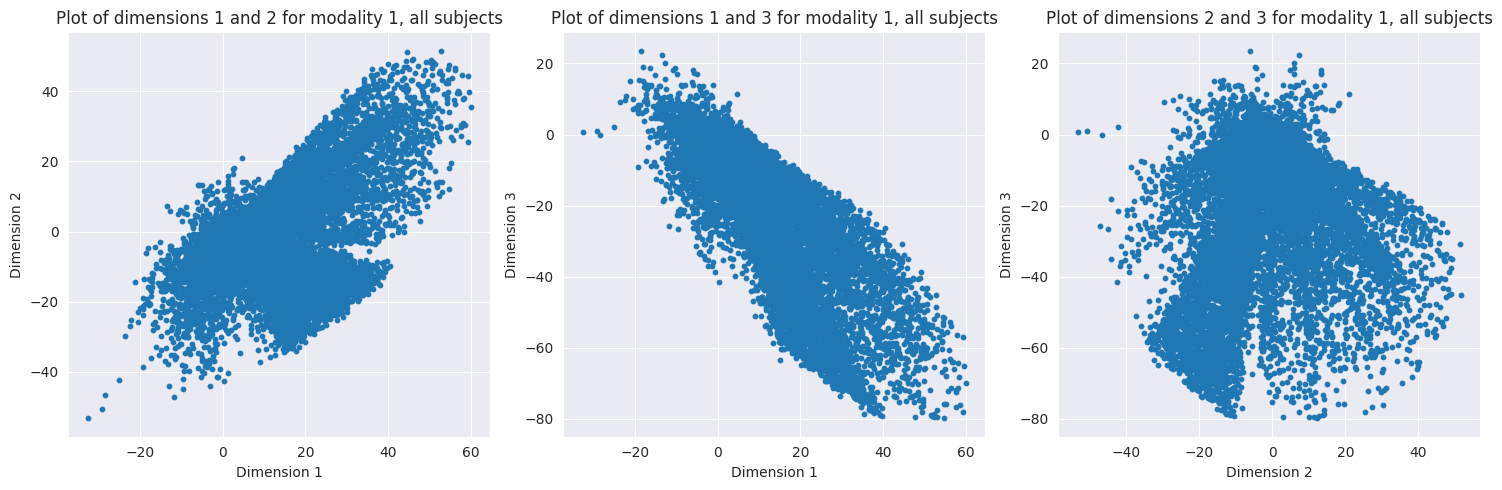

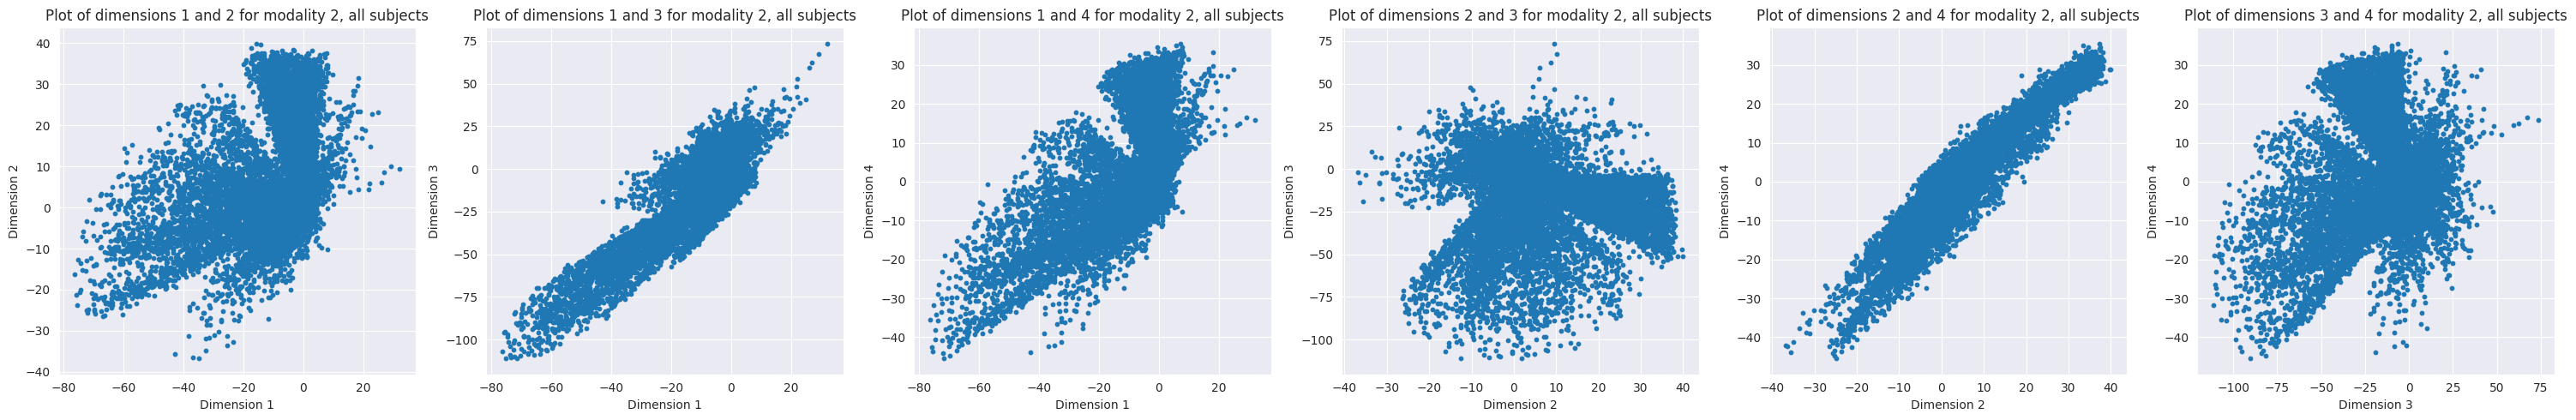

In [49]:
hf.plot_scatter_pairs_observed(y_actual)

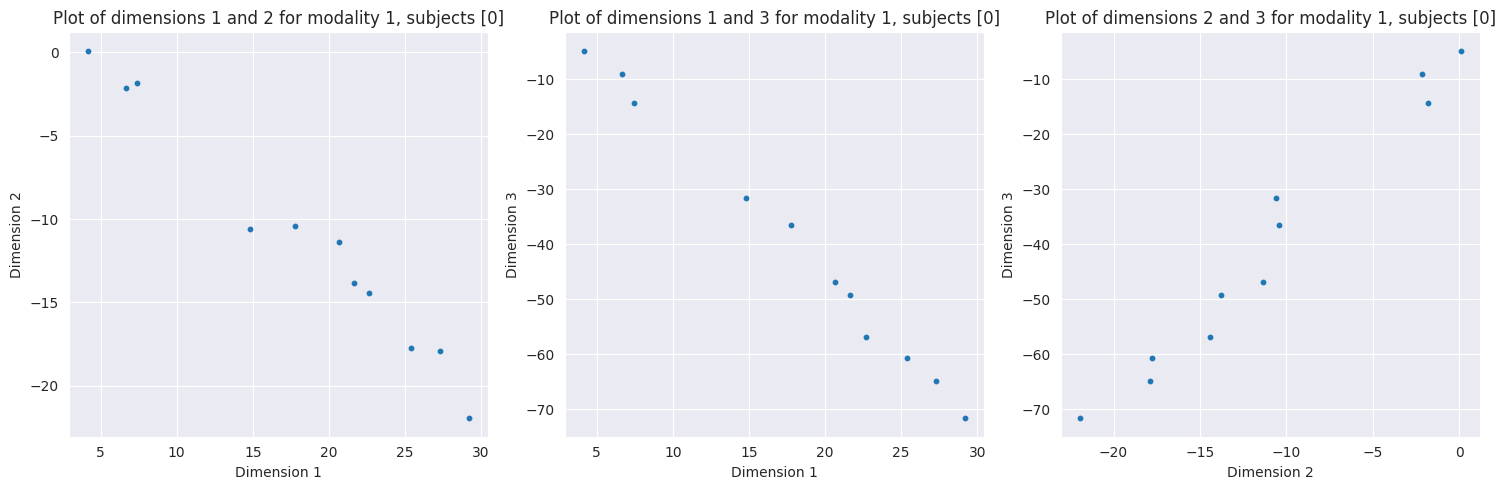

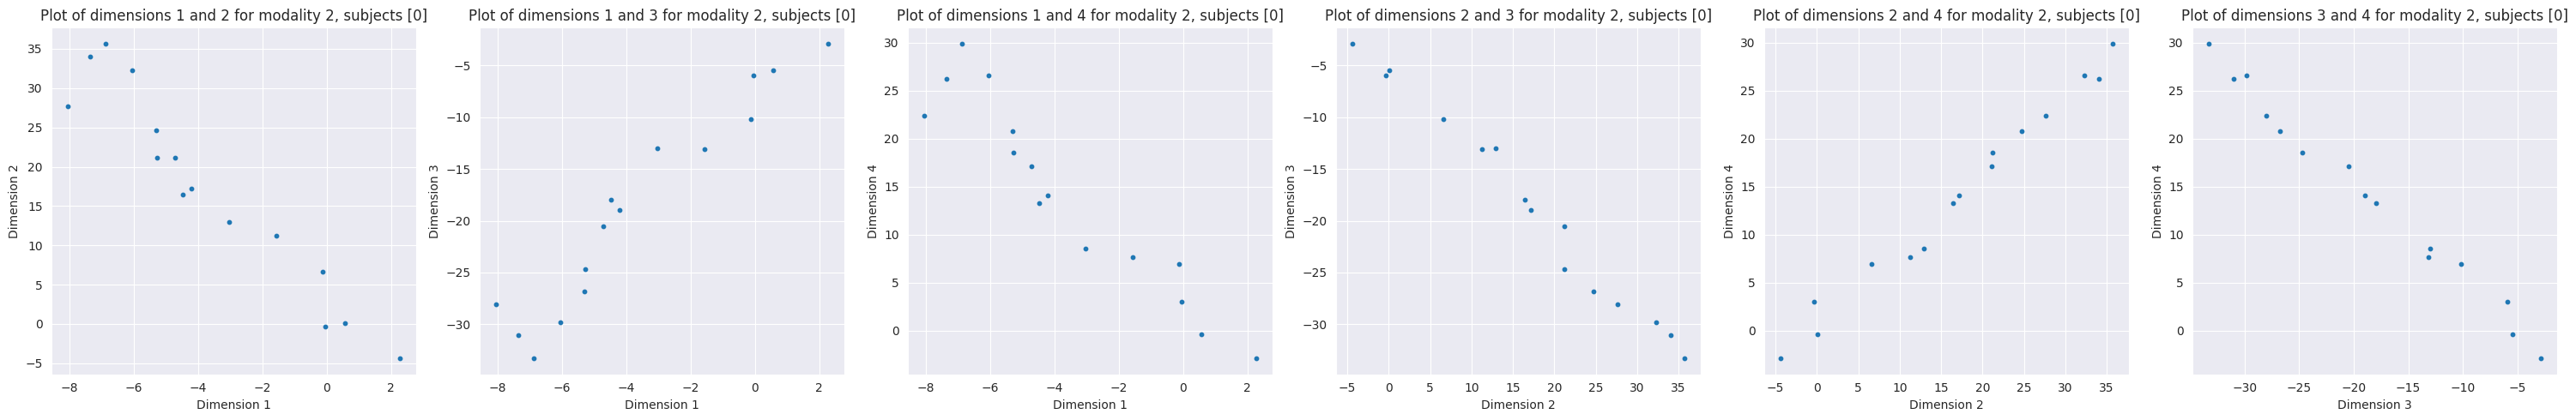

In [50]:
hf.plot_scatter_pairs_observed(y_actual, subject_indices=[0])

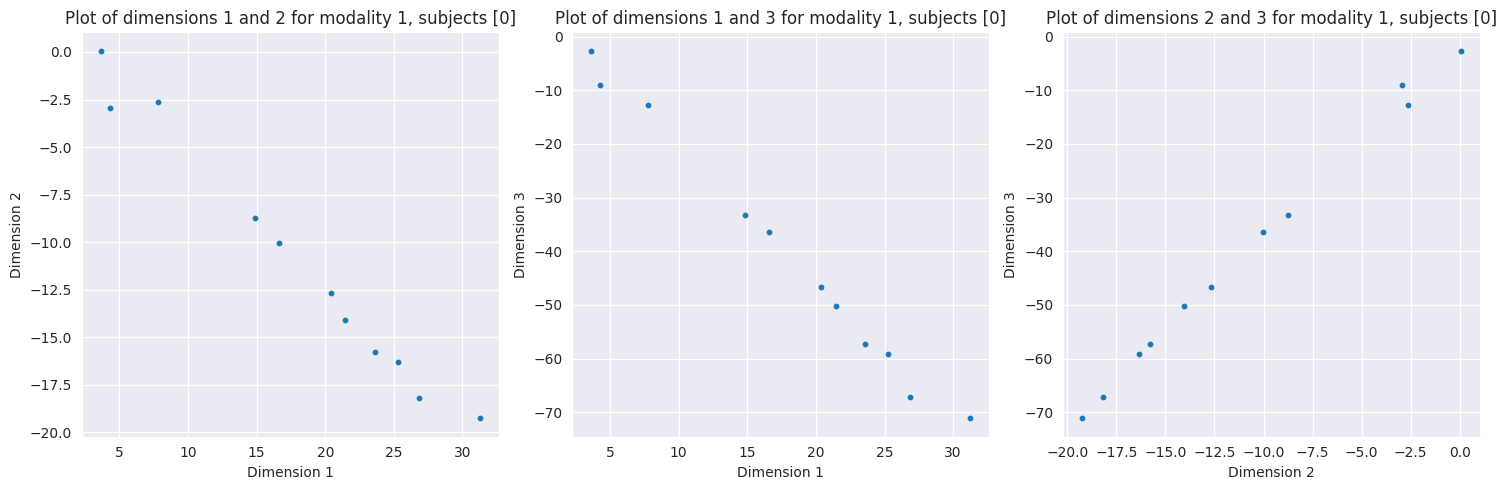

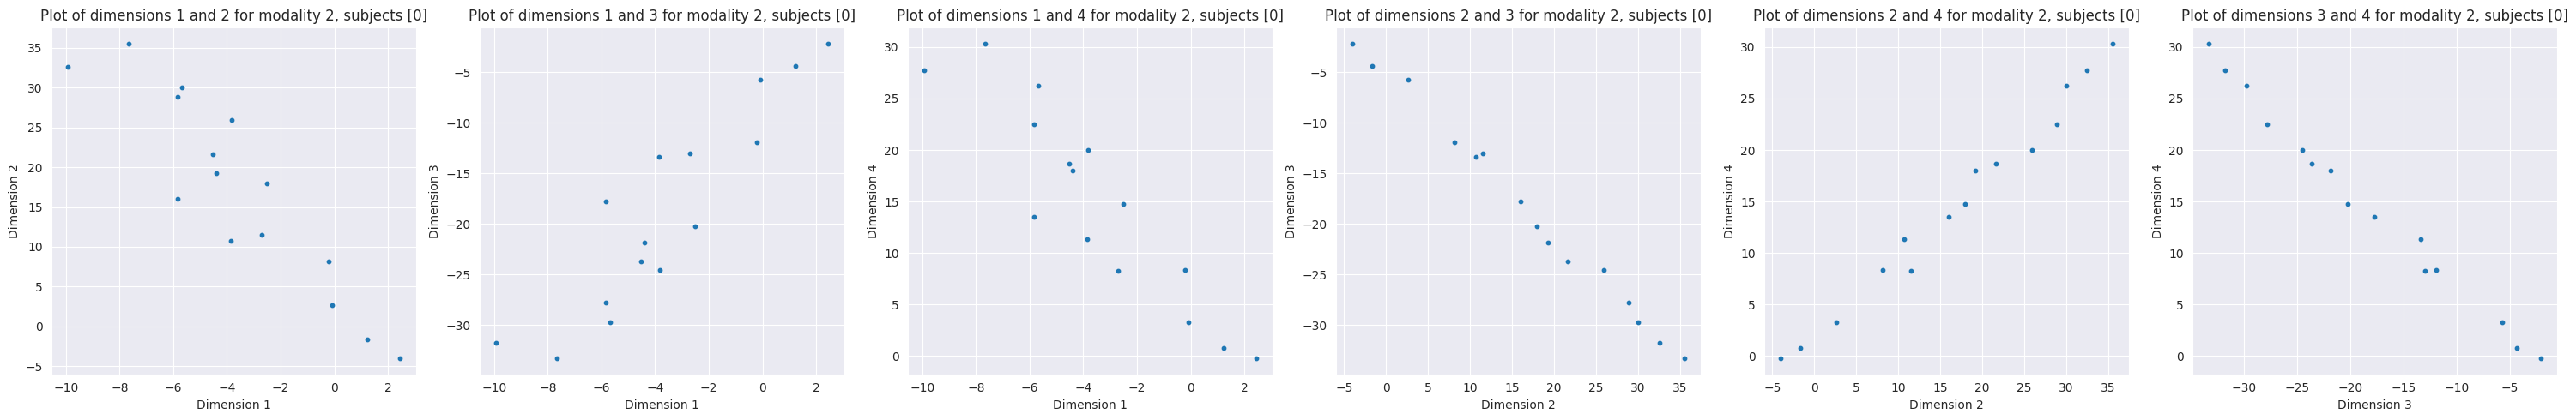

In [51]:
hf.plot_scatter_pairs_observed(y_recon, subject_indices=[0])